# Create DEM and Hillshade from point cloud data in Python

*Written by: Men Vuthy, 2022*

---


You can also run the code here in Google Colab. Try clicking button below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Mgriz881tcbPgUFjJ5J9tqaLVZ2n2YhL#scrollTo=GrfY4vJwzODy)

### Objective

*   Convert LiDAR point cloud data in `.las` file to digital elevation model (dem) and hillshade
*   Save and export dem as raster file `.tiff`





### Code

**1. Create DEM from point cloud data**

Install necessary modules:

```
!pip install rasterio
!pip install pylas
!pip install earthpy

```



Import modules

In [1]:
import pylas
import rasterio
from rasterio.crs import CRS
from rasterio.transform import Affine
import numpy as np
import earthpy.spatial as es
from scipy.interpolate import griddata
from matplotlib.cbook import get_sample_data
from matplotlib.colors import LightSource
import matplotlib.pyplot as plt
%matplotlib inline

Move to working directory

In [2]:
cd /content/drive/MyDrive/Colab Notebooks/Porfolio/LiDAR

/content/drive/MyDrive/Colab Notebooks/Porfolio/LiDAR


Read `.las` file which is the input LiDAR point cloud data 

In [3]:
# Import input LiDAR data
inFile = pylas.read('data/data.las')

Accessing file attributes and dimensions

In [4]:
# Count total point in point cloud
print('The total point is:', inFile.header.point_count)

The total point is: 26694756


In [5]:
# List of available dimensions in the file
inFile.point_format.dimension_names

('X',
 'Y',
 'Z',
 'intensity',
 'return_number',
 'number_of_returns',
 'scan_direction_flag',
 'edge_of_flight_line',
 'classification',
 'synthetic',
 'key_point',
 'withheld',
 'scan_angle_rank',
 'user_data',
 'point_source_id',
 'red',
 'green',
 'blue')

In [6]:
# Access VLRs
VLRList = inFile.vlrs
print(VLRList)

[<GeoKeyDirectoryVlr(25 geo_keys)>, <GeoDoubleParamsVlr([c_double(0.017453292519943278), c_double(6378137.0), c_double(298.257222101), c_double(0.0), c_double(0.0), c_double(0.0), c_double(0.0), c_double(0.0), c_double(0.0), c_double(0.0), c_double(0.0), c_double(1.0), c_double(-117.00000000000001), c_double(0.0), c_double(500000.0), c_double(0.0), c_double(0.9996)])>, <GeoAsciiParamsVlr(['NAD83|NAD83 / UTM zone 11N|'])>]


To retrieve a particular vlr from the list there are 2 ways: `VLRList.get()` and `VLRList.get_by_id()`

In [7]:
# Get spatial reference system from VLRs
VLRList.get('GeoAsciiParamsVlr')[0]

<GeoAsciiParamsVlr(['NAD83|NAD83 / UTM zone 11N|'])>

From the information of srs from VLRs, we can easily determine the EPSG code by just googling it or searching from [Spatial Reference](https://spatialreference.org). As in this case, the coordinate reference of `NAD83|NAD83 / UTM zone 11N` has epsg projection of `EPSG:26911`.

To create digital elevation model, 3 dimensions (X, Y, and Z) will be used as input for `scipy` function called  [`griddata(points, values, (x,y), method='linear')`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html). Next, let's determine all variables.

In [8]:
# Assign point list
points = list(zip(inFile.x, inFile.y))

In [9]:
# Assign elevation variable
elevation = inFile.z

In [10]:
# Assign grid resolution in meter
resolution = 1

# Create coord ranges over the desired raster extension
xRange = np.arange(inFile.x.min(), inFile.x.max() + resolution, resolution)
yRange = np.arange(inFile.y.min(), inFile.y.max() + resolution, resolution)

In [11]:
# Create arrays of x,y over the raster extension
gridX, gridY = np.meshgrid(xRange, yRange)

In [12]:
# Interpolate over the grid
dem = griddata(points, elevation, (gridX, gridY), method='linear')

So now, the DEM is created based on points and grid. Let's check the shape of DEM.

In [13]:
# Chekck the shape of dem
print(dem.shape)

(253, 618)


The DEM can be visualized as follows:

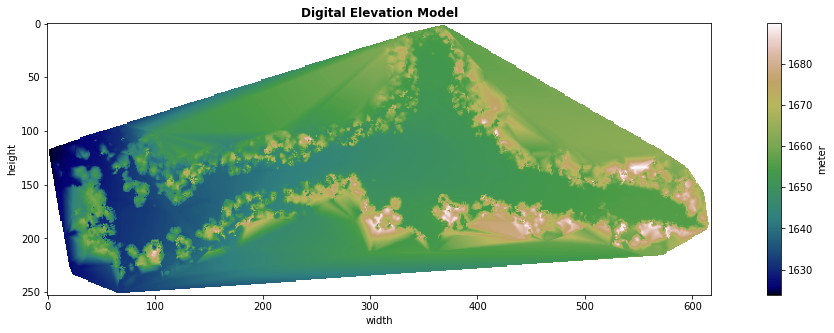

In [14]:
# Create figure
fig = plt.figure(figsize=[20, 5])

# Plot dem
plt.imshow(dem, cmap='gist_earth')

# Customize plot
plt.colorbar(label='meter')
plt.title('Digital Elevation Model', fontweight='bold')
plt.xlabel('width')
plt.ylabel('height')

# Show plot
plt.show()

With DEM array, it's also easy to create hillshade using function `es.hillshade()` in `earthpy` module 

In [15]:
# Create and plot the hillshade with earthpy
hillshade = es.hillshade(dem, azimuth=30, altitude=30)

The hillshade can be visualized as follows:

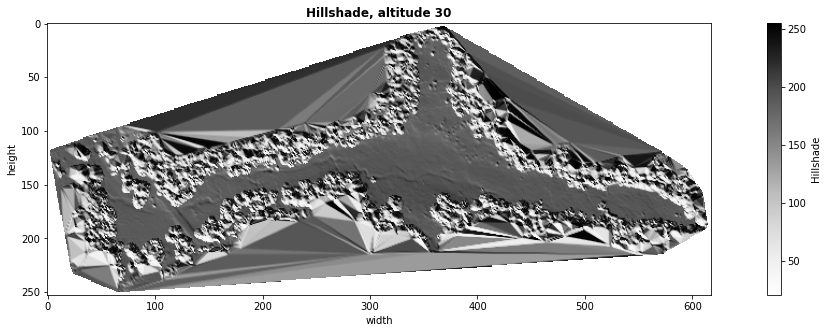

In [16]:
# Create figure
fig = plt.figure(figsize=[20, 5])

# Plot dem
plt.imshow(hillshade, cmap='Greys')

# Customize plot
plt.colorbar(label='Hillshade')
plt.title('Hillshade, altitude 30', fontweight='bold')
plt.xlabel('width')
plt.ylabel('height')

# Show plot
plt.show()

**2. Save and export dem and hillshade as** `.tiff` **files**

To write numpy array to raster file, some metadata must be added such as transform, crs, shape, etc. More details are available in [rasterio module](https://rasterio.readthedocs.io/en/latest/quickstart.html#saving-raster-data).

As mentioned above, the coordinate reference system of this elevation data is `NAD83|NAD83 / UTM zone 11N` which has epsg projection of `EPSG:26911`.

In [17]:
# Set coordinate reference system
crs = CRS.from_epsg(26911)

print(crs.data)

{'init': 'epsg:26911'}


In [18]:
# Define transform array
transform = Affine.translation(gridX[0][0]-resolution/2, gridY[0][0]-resolution/2)*Affine.scale(resolution,resolution)
transform

Affine(1.0, 0.0, 274322.467,
       0.0, 1.0, 4144468.334)

Export DEM to raster file

In [19]:
# Register metadata
out_image = rasterio.open('/content/out_dem.tif',
                                'w',
                                driver = 'GTiff',
                                height = dem.shape[0],
                                width = dem.shape[1],
                                count = 1,
                                dtype = dem.dtype,
                                crs = crs,
                                transform = transform,
                                )

# Write image
out_image.write(dem,1)
out_image.close()

Export hillshade to raster file

In [20]:
# Register metadata
out_image = rasterio.open('/content/out_hillshade.tif',
                                'w',
                                driver = 'GTiff',
                                height = hillshade.shape[0],
                                width = hillshade.shape[1],
                                count = 1,
                                dtype = hillshade.dtype,
                                crs = crs,
                                transform = transform,
                                )

# Write image
out_image.write(hillshade,1)
out_image.close()

Finally, we can see how to convert LiDAR point cloud data in `.las` file to digital elevation model (dem) and hillshade, then export them to a raster files.



---




